In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

city_daily_temperature_df = pd.read_csv("Datasets/city-daily-temperature.csv")
global_country_info_df = pd.read_csv("Datasets/global-country-information.csv")
print(city_daily_temperature_df.shape)
print(global_country_info_df.shape)

In [151]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [152]:
# Preprocessing City Daily Temperature
# We only want to look at data from 2000 onward 
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['Year'] >= 2000]

# Filtering invlaid temperatures
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] <= 134]
city_daily_temperature_df = city_daily_temperature_df[city_daily_temperature_df['AvgTemperature'] != -99]

# Formatting the date 
city_daily_temperature_df['Date'] = pd.to_datetime(city_daily_temperature_df[['Year', 'Month', 'Day']], errors='coerce')

# Renaming countries
country_remappings = {
    'Congo': 'Democratic Republic of the Congo', 
    'US': 'United States',
    'The Netherlands' : 'Netherlands',
    'Equador' : 'Ecuador',
    'Myanmar (Burma)' : 'Myanmar',
    'Serbia-Montenegro' : 'Montenegro'
}
city_daily_temperature_df['Country'] = city_daily_temperature_df['Country'].replace(country_remappings)

# Organizing data 
avg_temp_per_year = city_daily_temperature_df.groupby('Year')['AvgTemperature'].mean().reset_index()
avg_temp_per_region_per_year = city_daily_temperature_df.groupby(['Region', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_year = city_daily_temperature_df.groupby(['Country', 'Year'])['AvgTemperature'].mean().reset_index()
avg_temp_per_country_per_month = city_daily_temperature_df.groupby(['Country', 'Month'])['AvgTemperature'].mean().reset_index()

# Number of countries
# unique_countries = country_groups.keys()
# num_countries = len(unique_countries)

# print("Unique", unique_countries)
# print("Number of countries", num_countries)
# print("Average Temperature Per Year")
# print(avg_temp_per_year)
# print("Average Temperature Per Region by Year")
# print(avg_temp_per_region_per_year)
# print("Average Temperature Per Country by Year") 
# print(avg_temp_per_country_per_year)
# print("Average Temperature Per Country by Month")
# print(avg_temp_per_country_per_month)

In [153]:
# Preprocessing Global Country Information
# 2023 data
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None)
pd.options.mode.chained_assignment = None

#---------------------DROPPING UNNECESSARY COLUMNS---------------------
global_country_info_df.drop(['Fertility Rate','Population: Labor force participation (%)','Maternal mortality ratio','Unemployment rate','Gross tertiary education enrollment (%)','Gross primary education enrollment (%)','Density\n(P/Km2)','CPI','Abbreviation','Gasoline Price','Armed Forces size','CPI Change (%)','Latitude','Longitude','Tax revenue (%)','Calling Code','Currency-Code','Official language','Total tax rate', 'Physicians per thousand', 'Minimum wage', 'Out of pocket health expenditure',], axis = 1, inplace = True)

#---------------------FIXING COUNTIRES NAME ISSUES---------------------
global_country_info_df.loc[150, ['Country', 'Largest city', 'Capital/Major City']] = ['São Tomé and Príncipe', 'São Tomé', 'São Tomé']
global_country_info_df.loc[176, ['Capital/Major City', 'Largest city']] = ['Nuku\'alofa', 'Nuku\'alofa']
global_country_info_df.loc[181, 'Largest city'] = 'Funafuti'
global_country_info_df.loc[156, ['Capital/Major City', 'Largest city']] = ['Singapore', 'Singapore']
global_country_info_df.loc[97, ['Capital/Major City', 'Largest city']] = ['Tripoli', 'Tripoli']
global_country_info_df.loc[24, 'Largest city'] = 'Bandar Seri Begawan'
global_country_info_df.loc[120, 'Largest city'] = 'Denigomodu'
global_country_info_df.loc[175, ['Capital/Major City', 'Largest city']] = ['Lomé', 'Lomé']
global_country_info_df.loc[37, ['Capital/Major City', 'Largest city']] = ['Bogotá', 'Bogotá']
global_country_info_df.loc[40, ['Capital/Major City', 'Largest city']] = ['San José', 'San José']
global_country_info_df.loc[76, ['Capital/Major City', 'Largest city']] = ['Reykjavík', 'Reykjavík']
global_country_info_df.loc[104, ['Capital/Major City', 'Largest city']] = ['Malé', 'Malé']
global_country_info_df.loc[112, ['Capital/Major City', 'Largest city']] = ['Chișinău', 'Chișinău']
global_country_info_df.loc[23, ['Capital/Major City', 'Largest city']] = ['Brasília', 'São Paulo']
global_country_info_df.loc[31, ['Capital/Major City']] = ['Yaoundé']
global_country_info_df.loc[136, ['Capital/Major City']] = ['Asunción']
global_country_info_df.loc[43, ['Largest city']] = ['Nicosia']
global_country_info_df.loc[168, ['Largest city']] = ['Stockholm']
global_country_info_df.loc[169, ['Largest city']] = ['Zurich']
global_country_info_df.drop([133, 73], inplace=True) # Getting rid of countrys where majority/all of the data is missing

global_country_info_df['Population'] = global_country_info_df['Population'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['GDP'] = global_country_info_df['GDP'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
global_country_info_df['Agricultural Land( %)'] = pd.to_numeric(global_country_info_df['Agricultural Land( %)'].str.replace('%', ''), errors='coerce')
global_country_info_df['Forested Area (%)'] = pd.to_numeric(global_country_info_df['Forested Area (%)'].str.replace('%', ''), errors='coerce')



#---------------------FIXING MISSING CO2-EMMISIONS IN DATAFRAME---------------------
def replace_missing_co2(df):
    for index, row in df[df['Co2-Emissions'].isna()].iterrows():
        closest_country = df.loc[df['Co2-Emissions'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Co2-Emissions'] = closest_row['Co2-Emissions']    
    return df


#---------------------FIXING MISSING BIRTH RATES IN DATAFRAME---------------------
def replace_missing_birth_rate(df):
    for index, row in df[df['Birth Rate'].isna()].iterrows():
        closest_country = df.loc[df['Birth Rate'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  # GDP is now a float
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Birth Rate'] = closest_row['Birth Rate']    
    return df

#---------------------FIXING MISSING URBAN POPULATION IN DATAFRAME---------------------
def replace_missing_urban(df):
    df['Urban_population'] = pd.to_numeric(df['Urban_population'].str.replace(',', ''), errors='coerce')
    for index, row in df[df['Urban_population'].isna()].iterrows():
        closest_country = df.loc[(df['Urban_population'].notna()) &  (df['Urban_population'] < df['Population']) & (df['Population'].notna()) ] 
        if closest_country.empty:
            continue  
        population_diff = closest_country['Population'] - row['Population']
        gdp_diff = closest_country['GDP'] - row['GDP'] 
        combined_diff = population_diff + gdp_diff
        sorted_indices = combined_diff.sort_values().index
        for idx in sorted_indices:
            closest_row = closest_country.loc[idx]
            if closest_row['Urban_population'] < row['Population']:
                df.at[index, 'Urban_population'] = closest_row['Urban_population']
                break
    return df

#---------------------FIXING MISSING LIFE EXPECTANCY IN DATAFRAME---------------------
def replace_missing_life_expectancy(df):
    for index, row in df[df['Life expectancy'].isna()].iterrows():
        closest_country = df.loc[df['Life expectancy'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Life expectancy'] = closest_row['Life expectancy']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_infant_mortality(df):
    for index, row in df[df['Infant mortality'].isna()].iterrows():
        closest_country = df.loc[df['Infant mortality'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP'])  
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Infant mortality'] = closest_row['Infant mortality']    
    return df

#---------------------FIXING MISSING INFANT MORTALITY IN DATAFRAME---------------------
def replace_missing_land(df):
    for index, row in df[df['Agricultural Land( %)'].isna()].iterrows():
        closest_country = df.loc[df['Agricultural Land( %)'].notna(), :] 
        population_diff = abs(closest_country['Population'] - row['Population'])
        gdp_diff = abs(closest_country['GDP'] - row['GDP']) 
        combined_diff = population_diff + gdp_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']         
    return df

#---------------------FIXING PERCENTAGES IN DATAFRAME---------------------
def correct_land_percentages(global_country_info_df):
    rows_to_replace = global_country_info_df[(global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) > 100]
    for index, row in rows_to_replace.iterrows():
        closest_country = global_country_info_df.loc[(global_country_info_df['Agricultural Land( %)'].notna()) & (global_country_info_df['Forested Area (%)'].notna()) & (global_country_info_df.index != index) & ((global_country_info_df['Agricultural Land( %)'] + global_country_info_df['Forested Area (%)']) <= 100)]
        population_diff = abs(closest_country['Population'] - row['Population'])
        land_diff = abs((closest_country['Agricultural Land( %)'] + closest_country['Forested Area (%)']) - 100)
        combined_diff = population_diff + land_diff
        closest_row = closest_country.loc[combined_diff.idxmin()]
        global_country_info_df.at[index, 'Agricultural Land( %)'] = closest_row['Agricultural Land( %)']
        global_country_info_df.at[index, 'Forested Area (%)'] = closest_row['Forested Area (%)']
    return global_country_info_df

global_country_info_df = replace_missing_co2(global_country_info_df)
global_country_info_df = replace_missing_birth_rate(global_country_info_df)
global_country_info_df = replace_missing_urban(global_country_info_df)
global_country_info_df = replace_missing_life_expectancy(global_country_info_df)
global_country_info_df = replace_missing_infant_mortality(global_country_info_df)
global_country_info_df = replace_missing_land(global_country_info_df)
global_country_info_df = correct_land_percentages(global_country_info_df)
global_country_info_df['Land Area(Km2)'] = global_country_info_df['Land Area(Km2)'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Co2-Emissions'] = global_country_info_df['Co2-Emissions'].str.replace(',', '', regex=False).astype(int)
global_country_info_df['Urban_population'] = global_country_info_df["Urban_population"].astype(int)
global_country_info_df = global_country_info_df.sort_values(by='Co2-Emissions', ascending=False)
global_country_info_df = global_country_info_df[['Country','Capital/Major City','Largest city','Population','Urban_population','GDP','Land Area(Km2)','Agricultural Land( %)','Forested Area (%)','Birth Rate','Infant mortality','Life expectancy','Co2-Emissions']]
global_country_info_df = global_country_info_df.reset_index(drop=True)
global_country_info_df.index = range(1, len(global_country_info_df) + 1)
#global_country_info_df

In [154]:
# Combining the yearly average temperatures by country with the global country information
comined_yearly_df = pd.merge(global_country_info_df, avg_temp_per_country_per_year, on='Country')

In [155]:
# Combining the monthly average temperatures with the global country information
month_dict = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}
combined_monthly_df = pd.merge(global_country_info_df, avg_temp_per_country_per_month, on='Country')
combined_monthly_df['Month'] = combined_monthly_df['Month'].replace(month_dict)

p-value: 0.0031386639347898357


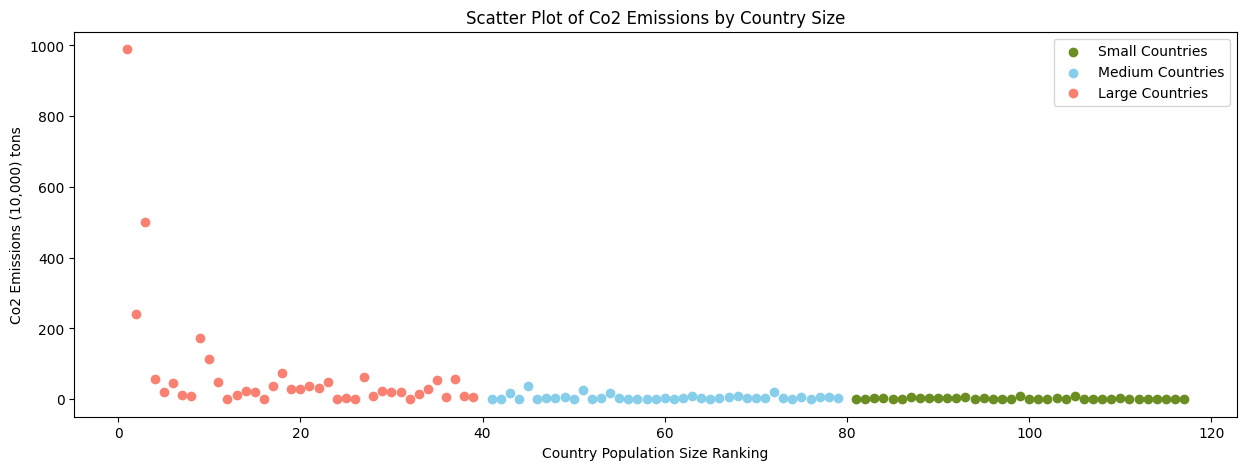

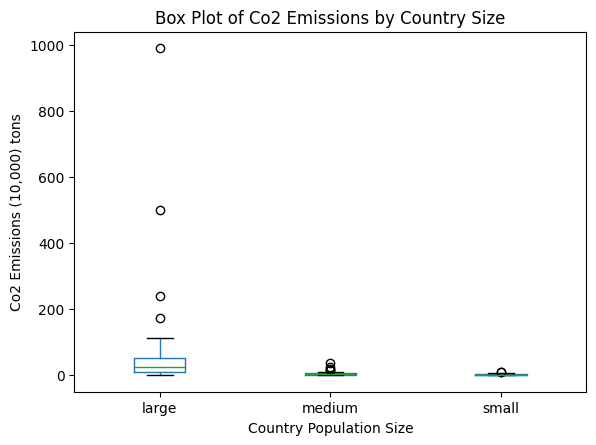

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
 large medium -68.0119 0.0106 -122.6734 -13.3505   True
 large  small -71.4524 0.0077 -126.8476 -16.0572   True
medium  small  -3.4404 0.9881  -58.8356  51.9547  False
-------------------------------------------------------


In [156]:
# ANOVA: Country size (small, medium, and large) vs Co2 emissions
first_inst_df = combined_monthly_df.drop_duplicates(subset='Country', keep='first')
first_inst_df = first_inst_df.sort_values(by='Population', ascending=False)
first_inst_df = first_inst_df.reset_index(drop=True)
first_inst_df.index = range(1, len(first_inst_df) + 1)
first_inst_df['Co2-Emissions'] = first_inst_df['Co2-Emissions']/10000
large_df = first_inst_df[0:39]
medium_df = first_inst_df[40:79]
small_df = first_inst_df[80:]
small_df['Country Size'] = 'small'
medium_df['Country Size'] = 'medium'
large_df['Country Size'] = 'large'
df_combined = pd.concat([small_df, medium_df, large_df], ignore_index=True)


f_stat, p_val = stats.f_oneway(large_df['Co2-Emissions'], medium_df['Co2-Emissions'], small_df['Co2-Emissions']) #drop the null hypothesis (0.003)
print("p-value:", float(p_val))
#plot scatterplot
plt.figure(figsize=(15,5))
plt.scatter(small_df.index, small_df['Co2-Emissions'], color='olivedrab', label='Small Countries')
plt.scatter(medium_df.index, medium_df['Co2-Emissions'], color='skyblue', label='Medium Countries')
plt.scatter(large_df.index, large_df['Co2-Emissions'], color='salmon', label='Large Countries')
plt.xlabel('Country Population Size Ranking')
plt.ylabel('Co2 Emissions (10,000) tons')
plt.title('Scatter Plot of Co2 Emissions by Country Size')
plt.legend()
plt.show()
#plot bloxplot
df_combined.boxplot(column='Co2-Emissions', by='Country Size')
plt.title('Box Plot of Co2 Emissions by Country Size')
plt.xlabel('Country Population Size')
plt.ylabel('Co2 Emissions (10,000) tons')
plt.suptitle("")  # To remove the default title
plt.grid()
plt.show()
tukey = pairwise_tukeyhsd(endog=df_combined['Co2-Emissions'], groups=df_combined['Country Size'], alpha=0.05)
print(tukey)

    ANOVA Test Conclusion
> I used the ANOVA test to examine whether CO2 emissions differ significantly based on country size by population. The null hypothesis in this case is that country size does not affect CO2 emissions. The alternative hypothesis is that the size of a country affects the amount of CO2 emissions it produces. I divided the countries into small, medium, and large categories, with a third of the total countries in each category. From this, I obtained a **p-value of 0.003**, which is below the significance threshold of 0.05. This indicates a statistically significant difference in CO2 emissions across the three country size categories, so **we reject the null hypothesis**.
    
> I then conducted a post-hoc analysis using Tukey's HSD to determine which specific country size groups differ in terms of their emissions. This test showed that the adjusted p-value between large and medium countries was 0.0106, between large and small countries it was 0.0077, and for medium and small countries it was 0.9881. Since 0.0106 and 0.0077 are less than our significance threshold, these categories are statistically significant. From this, we can gather that **large countries have significantly higher emissions** compared to medium and small countries. We can also conclude that CO2 emissions are similar for small and medium countries.
***

In [157]:
# Chi-Square: Top 10 countries by emission countries compare vs remaining countries

In [158]:
# Z-Test: Average temperature vs Co2 emissions